In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ph_scan import *

#### Let's try to zoom in on the areas where the surveys were done

In [2]:
# -- read in the survey coordinates
spath = os.path.join("..", "supplementary", "sites_geocoded.csv")
sites = pd.read_csv(spath)
lats  = sites.latitude.dropna().values
lons  = sites.longitude.dropna().values

In [3]:
# -- get the complete list of imaging coordinates
cpath  = os.path.join("..", "data", "Delivery", "*", "*P00*MUL", "*.IMD")
clist  = np.array(sorted(glob.glob(cpath)))
cstrs  = [[line for line in open(i, "r")] for i in clist]
coords = np.zeros([len(clist), 4])

for ii, cstr in enumerate(cstrs):
    coords[ii] = [[float(line.split("=")[1][:-2]) for line in cstr if "ULLat" in line][0], 
                  [float(line.split("=")[1][:-2]) for line in cstr if "ULLon" in line][0], 
                  [float(line.split("=")[1][:-2]) for line in cstr if "LRLat" in line][0], 
                  [float(line.split("=")[1][:-2]) for line in cstr if "LRLon" in line][0]]

In [4]:
# -- let's try the first one
tlat = lats[0]
tlon = lons[0]
ind  = (tlat < coords[:, 0]) & (tlat >= coords[:, 2]) & (tlon >= coords[:, 1]) & (tlon < coords[:, 3])
ullat, ullon, lrlat, lrlon = coords[ind][0]
scan = PhScan(clist[ind][0].replace(".IMD", ".TIF"))
nrow, ncol = scan.rgb.shape[:2]

reading ../data/Delivery/057773250120_01/057773250120_01_P004_MUL/17SEP29170130-M2AS-057773250120_01_P004.TIF...
extracting to array...  (extracted in 0.0493290424347s)
rescaling...


In [5]:
# -- interpolate onto pixels
trow = int(np.round(nrow * (tlat - ullat) / (lrlat - ullat)))
tcol = int(np.round(ncol * (tlon - ullon) / (lrlon - ullon)))

In [6]:
# -- convert RGB to grayworld
rgb_ma = np.ma.array(scan.rgb)
rgb_ma.mask = np.dstack([rgb_ma.sum(2) == 0 for i in range(3)])
fac  = rgb_ma.mean(0).mean(0)
fac /= fac.max()

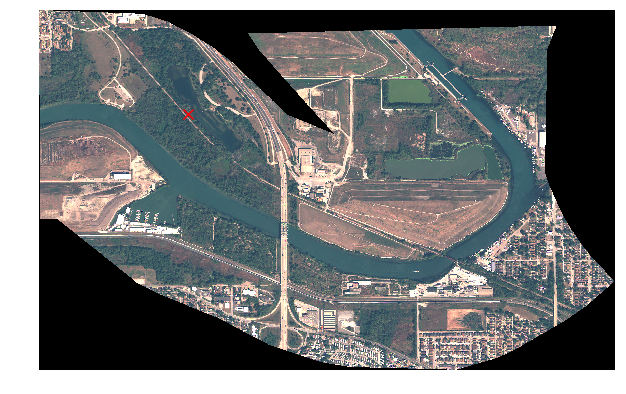

In [10]:
# -- make the plot
xs      = 8.0
ys      = xs * float(nrow) / float(ncol)
fig, ax = plt.subplots(figsize=[xs, ys])
fig.subplots_adjust(0, 0, 1, 1)
ax.axis("off")
ax.scatter([tcol], [trow], c="r", marker="x", s=100)
ax.imshow(((3.0 * scan.rgb / fac).clip(0, 1)))
plt.show()
fig.savefig(os.path.join("..", "output", "check_geocoded.png"), clobber=True)

#### Looks like the geocodes can be offset from the trajectories by quite a bit...